<a href="https://colab.research.google.com/github/alouwyck/vives-intro-to-ai/blob/main/topic3/topic3_state_space_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

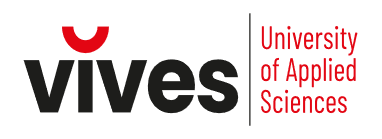<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
VIVES BUSINESS ACADEMY<br>
Academic Year 2023-2024<br>
Andy Louwyck

---



---



# **STATE SPACE REPRESENTATION**

This notebook demonstrates how the **state space representation** is applied to model the problem of **finding a path in a maze**. Modeling the problem is the first step to solve the problem applying **search algorithms**. The use of search algorithms will be covered in the next topics.

## `SearchExerciser`

To illustrate the basic concepts discussed in the topics about search algorithms, we will use the `SearchExerciser` package developed by Stefaan Haspeslagh and Andy Louwyck at Vives University of Applied Sciences. The package can be downloaded or cloned from the following GitHub repository: https://github.com/alouwyck/SearchExerciser.

To clone the repository, we execute the statements in the cell below. Note that [Google Colab](https://colab.research.google.com/) is used as environment to run the notebooks, although this is not required.

In [ ]:
import os, shutil

# remove directory 'SearchExerciser' first if it already exists
path = "SearchExerciser"
if os.path.exists(path):
    shutil.rmtree(path)

# clone SearchExerciser repository from Github
!git clone https://github.com/alouwyck/SearchExerciser

# put SearchExerciser package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'SearchExerciser'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 281 (delta 20), reused 25 (delta 12), pack-reused 248
Receiving objects: 100% (281/281), 349.00 KiB | 4.20 MiB/s, done.
Resolving deltas: 100% (168/168), done.


Once the package is cloned into our environment, we import the following classes from module `maze`:

In [ ]:
from SearchExerciser.maze import Maze, Position, State, Path, Move, Left, Right, Up, Down

The meaning and the purpose of these classes will be explained in the sections below.

## Creating a maze

As we intend to solve the problem of finding a path in a maze applying the state space representation, we first need to be able to construct a maze. A maze can be represented as a **grid** consisting of a number of **rows** and **colums**. This is a two-dimensional structure similar to a table or a matrix. In Python (and other programming languages) there are several ways of implementing such a 2D array.

`SearchExerciser` has a class called `Maze` that is used to define a maze. Using static method `create`, we can create a `Maze` object. The method accepts a list of strings, and each charachter in the strings represents a grid cell:

- `*`: cell where we start
- `o`: cell with the exit or goal
- `#`: 'forbidden' barrier cell
- `.`: 'free-to-walk' cell

To start, let's create a very simple maze consisting of 3 rows and 3 columns. The start is in the upper left corner and the goal in the lower right corner. There is one barrier cell in the middle of the grid:

In [ ]:
maze = Maze.create(["*..",
                    ".#.",
                    "..o"])
maze

*..
.#.
..o

Note that `SearchExerciser` only allows 'square' grids having an equal number of rows and columns. That number is called the **size** of the grid:

In [ ]:
maze.size

3

The total number of cells in the grid is equal to the square of the grid size:

In [ ]:
maze.size**2

9

The list of strings has been converted into a [NumPy](https://numpy.org/) array of integers assigned to attribute `grid`. Do you see which number is assigned to the different cell types?

In [ ]:
maze.grid

array([[0, 1, 1],
       [1, 2, 1],
       [1, 1, 3]])

Using an numeric array, it is easy to plot the grid using [matplotlib](https://matplotlib.org/). The `Maze` class has method `plot` to do the job for us:

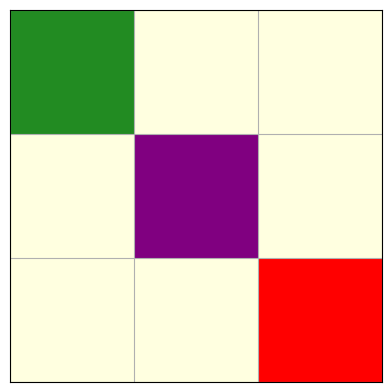

In [ ]:
maze.plot()

The `plot` method nicely visualizes the **configuration** of the maze!

## Maze position

To know where exactly we are in the maze, we need our current **position**, which is the cell we are currently in. But how do we implement a position in Python? Just like in Excel, a specific cell can be referred to unambiguously using the unique combination of its **row and column indices**. We call this a grid **coordinate**. In Python a tuple can be used to store these row and column indices:

> `position = (row_index, column_index)`

Note that the first entry in the tuple is the row index!

`SearchExerciser` has a class `Position` to implement a position in the maze. For instance, invoking method `get_start_position` returns the start position, which is the coordinate of the cell where we have to start:

In [ ]:
maze.get_start_position()

(0, 0)

Note that the rows are numbered from top to bottom (which is the opposite of the direction of the y-axis!), and the columns from left to right (which is the direction of the x-axis). Similarly, we can get the coordinate of the goal by calling method `get_goal_position`:

In [ ]:
maze.get_goal_position()

(2, 2)

Of course we can instantiate a `Position` object to store another position in the maze:

In [ ]:
p = Position(1, 0)
p

(1, 0)

Using class `Position` instead of a Python tuple, it is easy to compare two grid positions:

In [ ]:
maze.get_start_position() == p

False

## State

The concept of **state** is essential in the state space representation. The objective of solving a search problem is to find one of the goal states starting from the initial state. Therefore, to model the search problem, it is crucial to find the right representation of all possible states, which is the **state space**.

`SearchExerciser` has a class `State` which conceptualizes a maze state as a position in the maze grid. That implies a `State` object is an aggregation of a `Maze` object and a `Position` object. The initial state of the maze we created is instantiated as follows:

In [ ]:
initial_state = State(maze, maze.get_start_position())
initial_state

(0, 0)

We see that the position of the starting cell is printed indeed. But what is the difference between a position and a state? A `Position` object has no information about the `Maze` object it refers to, while the `State` object has. For instance, it contains a method `is_goal` to check if the state it implements is a **goal state**:

In [ ]:
initial_state.is_goal()

False

Of course, the initial state is not a goal state, but our goal position is:

In [ ]:
goal_state = State(maze, maze.get_goal_position())
goal_state.is_goal()

True

Can you see why this method is an important one? Indeed, it will be used by the search algorithms to check if a state is the goal state. If we would forget to implement this check, a search algorithim would be endlessly trying to find the solution...

## Production rules

The **production rules** explain how we can go from one state to another. In the maze example, they define in which direction we can go and how many steps we may take. To keep it simple, we can only move to an adjacent cell, which means we can go one cell to the left (L), to the right (R), up (U), or down (D). A diagonal move is not allowed and neither is 'jumping' over cells.

To known which production rules are valid, we simply check `Maze` attribute `rules`:

In [ ]:
maze.rules  # L, R, U, D by convention!

[L, R, U, D]

Don't forget the order of the rules is relevant to some search algorithms! By convention, we implement **left, right, up, down**, although it is possible to change that order, in which case some algorithms may give a different result!

How can we select production rule `R`?  It is the second entry in the list of `rules`, which means it has index `1`:

In [ ]:
maze.rules[1]

R

The `R` object actually is an instance of class `Right`, which is a subclass of the `ProductionRule` class:

In [ ]:
type(maze.rules[1])

SearchExerciser.maze.Right

## Move

It is good to know how we can move in the maze, which is formalized by defining the set of production rules. But of course, we also have to be able to actually move in the maze! Hence, class `Move` in the `SearchExerciser` package!

A **move** is applied to a given state, which explains why a `Move` object is created using a `State` object and a specific production rule. That is the difference between a move and a production rule: the first applies to a specific state, the latter doesn't.

Suppose we want to go down starting from the initial state. Instantiating the following `Move` object will do the job:

In [ ]:
initial_state = State(maze, maze.get_start_position())  # the initial state
down = maze.rules[-1]  # D is the last production rule -> index -1
move_down = Move(initial_state, down)
move_down

D

The `Move` object is represented by its production rule, but recall that it also contains the state to which the rule is applied:

In [ ]:
move_down.state

(0, 0)

Applying the production rule to the state is simply done by calling method `apply`:

In [ ]:
new_state = move_down.apply()
new_state

(1, 0)

Method `apply` returns the new state. Suppose we want to go to the left:

In [ ]:
move_left = Move(new_state, maze.rules[0])
move_left

L

Of course this move is not **valid** as we are in the first column of the grid and we cannot leave the maze by crossing its boundaries! That's something the search algorithms should check, and therefore, class `Move` has a method `is_valid`:

In [ ]:
move_left.is_valid()

False

Going to the left is not valid indeed, while `move_down` was valid:

In [ ]:
move_down.is_valid()

True

Let's implement a sequence of valid moves to get from start to goal:

In [ ]:
state = State(maze, maze.get_start_position())  # the initial state
print('initial state:', state)

for step in [Down(), Down(), Right(), Right()]:  # steps required to find the goal
    move = Move(state, step)  # create move
    if move.is_valid():  # check if move is valid
        state = move.apply()  # apply move
        print('move:', move)
        print('new state:', state)
    else:
        print('invalid move:', step)
        break
    if state.is_goal():  # check if goal is reached
        print('goal reached!')
        break

initial state: (0, 0)
move: D
new state: (1, 0)
move: D
new state: (2, 0)
move: R
new state: (2, 1)
move: R
new state: (2, 2)
goal reached!


It's good practice to create a function which allows us to reuse this piece of code:

In [ ]:
def walk(maze, steps):
    """
    maze is a Maze object
    steps is a list of ProductionRule objects
    """
    state = State(maze, maze.get_start_position())  # the initial state
    print('initial state:', state)
    for step in steps:  # go through the given steps
        move = Move(state, step)  # create move
        if move.is_valid():  # check if move is valid
            state = move.apply()  # apply move
            print('move:', move)
            print('new state:', state)
        else:
            print('invalid move:', step)
            break
        if state.is_goal():  # check if goal is reached
            print('goal reached!')
            break

Testing the function:

In [ ]:
walk(maze, [Down(), Down(), Right(), Right()])

initial state: (0, 0)
move: D
new state: (1, 0)
move: D
new state: (2, 0)
move: R
new state: (2, 1)
move: R
new state: (2, 2)
goal reached!


Nice! And what if we include an invalid step in the list of steps?

In [ ]:
walk(maze, [Right(), Right(), Up(), Up()])

initial state: (0, 0)
move: R
new state: (0, 1)
move: R
new state: (0, 2)
invalid move: U


Ok, it identifies the invalid move and stops the execution, as it should!

## Path

It is clear we want to find a path that guides us from start to goal, and in fact, we want to find the shortest path! How we find the shortest path is the subject of the next topics. For now, we are focusing on finding a path as we did in previous section for the simple 3x3 maze we've created.

The **path** is defined as the sequence of states we go through, and as you may except, `SearchExerciser` implements a class `Path` to help us storing this sequence.

We modify our function `walk` and make use of class `Path` to save the succession of states we are creating. We name this new function `create_path`:

In [ ]:
def create_path(maze, steps):
    """
    maze is a Maze object
    steps is a list of ProductionRule objects
    """
    state = State(maze, maze.get_start_position())  # the initial state
    print('initial state:', state)
    states = [state]  # list in which we will store the subsequent states
    for step in steps:  # go through the given steps
        move = Move(state, step)  # create move
        if move.is_valid():  # check if move is valid
            state = move.apply()  # apply move
            print('move:', move)
            print('new state:', state)
            states.append(state)  # append new state to list of states
        else:
            print('invalid move:', step)
            break
        if state.is_goal():  # check if goal is reached
            print('goal reached!')
            break
    return Path(states)  # return list of states as Path object

What has changed? Well, we now keep track of the states by appending them to list `states`. This list is passed to the `Path` constructor that creates a `Path` object which is returned by the function. Let's see how this works:

In [ ]:
path = create_path(maze, [Down(), Down(), Right(), Right()])

initial state: (0, 0)
move: D
new state: (1, 0)
move: D
new state: (2, 0)
move: R
new state: (2, 1)
move: R
new state: (2, 2)
goal reached!


If you print the `path`, then you see the path is indicated by crosses `x`:

In [ ]:
path

x..
x#.
xxx

But what's really cool about this `Path` class is that you are able now to visualize the path in the maze! To do so, simply call method `plot`:

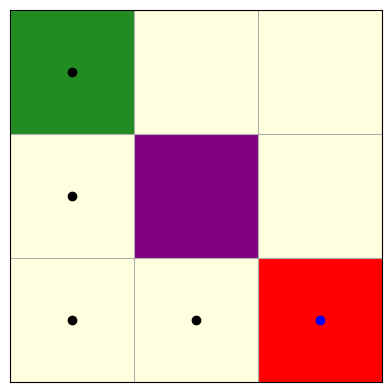

In [ ]:
path.plot()

And there is even a 'live' plot:

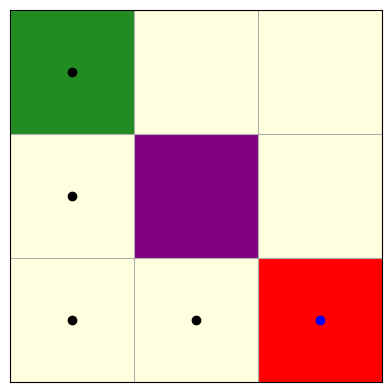

In [ ]:
path.plot_live()

That's nice! But isn't that a very cumbersome way just to implement the path you have to follow to find the exit of a maze? It sure is! But this is of course a very simple problem, while the state space respresentation is meant to solve all kinds of search problems, not only maze problems! For instance, think of a more complicated problem such as playing chess. In that case, modeling the problem using the state space representation is a much more convenient way than trying to solve the problem 'intuitively' without formalizing it.

In fact, the classes presented in this topic are specific implementations for the maze problem. If you take a look at the code of the `SearchExerciser` package, then you will see that these classes inherit attributes and methods from base classes with the same name, following an **object oriented** approach. Solving new search problems thus requires the implementation of specific subclasses that inherit the logic from these base classes.

Finally, what is missing here, is the use of an efficient search algorithm to solve the problem. Now we have been hard-coding the steps to go from start to goal, but in real-life problems, that is not always possible, as there are mostly too many options. In other words, the number of possible combinations is too large. To search the enormous state space of real-life problems, not only efficient algorithms are required, but also intelligent algorithms! Welcome to the world of **artificial intelligence**!

## Exercise

Using static method `create_random` of the `Maze` class, it is possible to create a random maze:

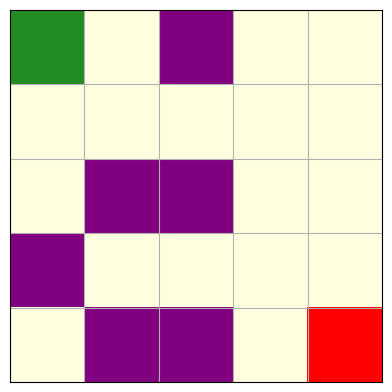

In [ ]:
maze = Maze.create_random(size=5,         # number of rows = number of columns
                          num_of_walls=6, # number of 'forbidden' barriers or walls
                          seed=0)         # random seed
maze.plot()

If you pass a `seed`, then the method will generate a random maze that is always the same. As you know, a random generator is not realy random, but pseudo-random, and by initializing its seed, it is possible to generate the same 'random' sequence of numbers over and over again.

Use the function `create_path` to implement a path to the goal. Does it also work to solve this specific search problem? If so, then we did a great job in generalizing the maze problem!

Now try to implement a search algorithm that is capable of finding a path to the goal, without the user giving a possible solution. Take into account the possibility there is no solution!

As you see, implementing such an algorithm from scratch is not as easy as it looks! The next topic will discuss some algorithms that are capable of finding a path without telling them which moves to take!

---